# Location, location, location (and size...)

I hope you find the kernel useful. If you catch some mistake or have any suggestion to improve it, please do not hesitate to write a comment. I posted this notebook mainly to understand what and where I need to improve most, so any constructive criticism is welcomed. Of course, I will try to implement the suggestions received. Thank you in advance and enjoy!

In [1]:
#import libraries for pre-processing
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from dateutil.parser import parse
from datetime import datetime
from scipy.stats import norm

# import all what you need for machine learning
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

## [1. A First Look to the dataset](#first_look)

## [2. Data Cleaning](#data_cleaning)
 * [2.1. Missing Values](#missing_data)
 * [2.2. Outliers](#outliers)
 * [2.3. Feature Engineering](#features)

## [3. Visualisations](#visualisation)
 * [3.1 Boxplot and histogram](#box)
 * [3.2 Time Series](#time)
 * [3.3 Scatterplot](#correlation)
 * [3.4 Map](#geo)

## [4. Machine Learning](#ml)
 * [4.1 Model Comparison](#compare)
 * [4.2 Fine Tuning](#tune)
    - *[a. Grid Search](#grid)*
    - *[b. Random  Search](#random)*
 * [4.3 Test set evaluation](#evaluate)

## [5. RF hyperparameters](#hyper)

<a id='first_look'></a>

# 1. A first look to the dataset
This section is dedicated to a very preliminary analysis of the dataset, where I will try mostly to understand what I am dealing with.

In [2]:
#load data
housing= pd.read_csv('C:/Users/EAMC/Desktop/melbourne-housing-market/Melbourne_housing_FULL.csv', sep=',')
#for kaggle housing= pd.read_csv('../input/Melbourne_housing_FULL.csv)

In [3]:
# visualize the first two rows for every column
housing.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
#Check the type of variables
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

There is something wrong with data types. Let's change that. For example, there is no reason why postcode is considered as a float while it's clearly a category. I'll take the time to change all the problematic types, one by one:
* Date. I will work with date later in the feature engineering section 
* change Bathroom and Car to integer Series
* Postcode is a categorical variable, not a numeric one
* Yearbuilt should be an integer
* Propertycount is a category

In [5]:
#change Postcode
housing['Postcode']= housing['Postcode'].astype('object')
#change Bathroom and car to integer. Before the transformation I need to convert all the missing values to 0. 
#lastly, change Propertycount to category
housing['Propertycount']= housing['Propertycount'].astype('object')

Finally, let's talk about Bedroom2. I decided to drop Bedroom2. 
This is for two main reasons:
- the overview is quite vague about the origin of this variable - 'Scraped # of Bedrooms (from different source)' 
- from a quick view of the database, it seems to be very similar to Number of Rooms. Let's check it with a simple scatterplot: as you can see below the relationship is almost perfectly linear, which tells me that they are almost a perfect match. I do not think that the variable provides additional information that Rooms. 

In [ ]:
sns.lmplot(data= housing, x='Bedroom2', y='Rooms')

In [5]:
#drop Bedroom2
housing= housing.drop(['Bedroom2'], axis=1)

In [ ]:
#check basic statistics
housing.describe()

There are some strange values in this table, so let's check this values before moving on:
* Check number of bathrooms (<1 and >7)
* check building area=0 and building area 44515 square meters
* check properties with YearBuilt > 2018

In [6]:
# check number of bathrooms
housing['Bathroom'].value_counts()

1.0     12969
2.0     11064
3.0      2181
4.0       269
5.0        77
0.0        46
6.0        16
7.0         4
8.0         3
9.0         1
12.0        1
Name: Bathroom, dtype: int64

It seems that 46 properties do not have the bathroom! I think they should be old houses with a common bathroom outside, or something like that, so I will restrain myself from considering them an error. Of course, I do find strange that there is a property with 12 bathrooms, though I guess it is technically possible. Let's take a look to houses with more than 7 bathrooms.

In [ ]:
housing.loc[housing.Bathroom>7].head()

In [ ]:
#check building area 
housing.loc[housing.BuildingArea<1].head()

In [ ]:
housing['BuildingArea'].loc[housing.BuildingArea<1].count()

Ok, so it appears that 77 houses do not have any building area. It may be that some of these values are simply data entry mistakes. Another possibility is that these properties were sold only because of their land, as building plots and that there was still no house in it. However, if this was not the case how come that we know for almost everyone of them YearBuilt, that is the year the house was built? In conclusion, I think there is something wrong with most of this subsample, so I will drop these rows.  

In [8]:
#use the unary operator ~ to delete the rows
housing = housing[~(housing['BuildingArea'] < 1)]  
#check the deletion
housing['BuildingArea'].loc[housing.BuildingArea<1].count()

0

In [9]:
#it is important now to reset the index, otherwise I will have some missing rows in my dataframe, which may be troublesome later.
housing = housing.reset_index()

The boxplot shows an outstanding outlier, with a building area of more than 40000 squared meters. Let's get a closer look to its values.

In [ ]:
sns.boxplot(data = housing, y = 'BuildingArea')

In [ ]:
housing.loc[housing.BuildingArea>40000]

Ok, so this seems a very large property with a lot of land. The building area value is probably an error, as it is bigger than the landsize, and considering that this house has 5 rooms and three bathrooms, it is fair to assume that it cannot be much larger than 500 squared meters. The median value for building area is 136. I will change this value to 445 squared meters, a tenth of its reported size, on account that I think it's possibly bigger than the average house, given the landsize. Of course this line of thought may be biased: I cannot exclude that the property was some kind of factory or company headquarters. I'll stop here for building area. 

In [10]:
#replace outlier building area
housing['BuildingArea'].replace(44515.0, 445, inplace=True)

In [11]:
# check YearBuilt > 2018
print(housing['YearBuilt'].loc[housing.YearBuilt>2018])
#replace 2106 with 2016 and 2019 with 2018
housing['YearBuilt'].replace([2106, 2019], [2016, 2018], inplace=True)

2453     2106.0
32960    2019.0
Name: YearBuilt, dtype: float64


<a id='data_cleaning'></a>

# 2. Data Cleaning

<a id='missing_data'></a>

## 2.1 Missing data

It's time to check how many missing data each variable has.

In [ ]:
# check missing data
housing.isnull().sum()

Many of the variables suffer from missing values. Building area is the most affected by them. I would like to explore it's relationship with price and at the same time evaluate whether it is better to impute the missing values with their mean or median. 

In [14]:
# We will save the "cured" data columns in variables
#first with the mean
priceWithMean = housing['Price'].fillna(housing['Price'].mean())
BAWithMean = housing['BuildingArea'].fillna(housing['BuildingArea'].mean())

#now with the median
priceMedian = housing['Price'].fillna(housing['Price'].median())
BAMedian = housing['BuildingArea'].fillna(housing['BuildingArea'].median())

In [15]:
missVIDsJoint = housing['Price'].isnull() | housing['BuildingArea'].isnull()
# missVIDsJoint now has a True for items that are missing an Age or a Fare value

In [20]:
# create a dictionary to indicate different colors, missing values will be orange
colorChoiceDict = {True: (1.0, 0.55, 0.0, 1.0), False: (0.11, 0.65, 0.72, 0.1)}

# create a column with color values using list comprehension
colorCol = [colorChoiceDict[val] for val in missVIDsJoint]

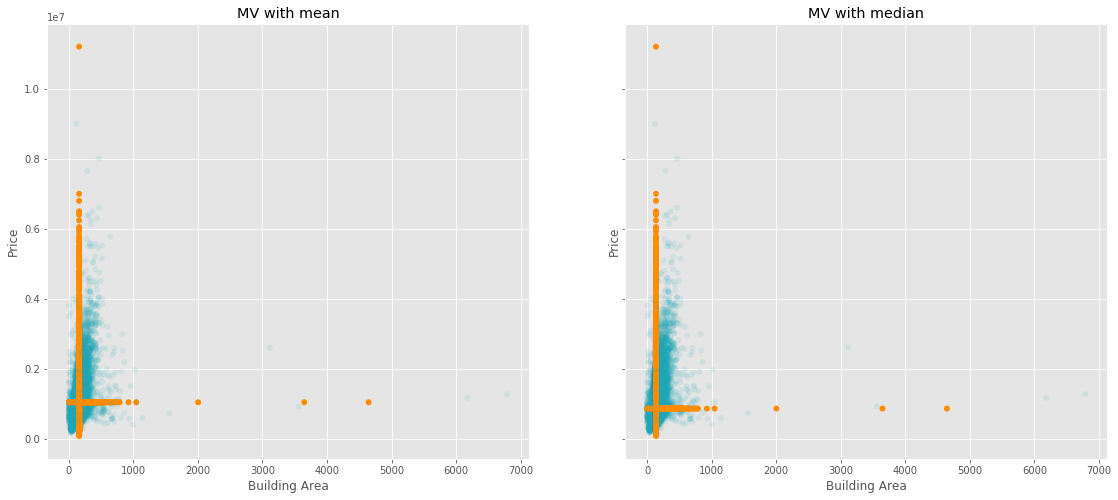

In [17]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(BAWithMean, priceWithMean, c = colorCol, linewidth='0')
ax1.set_title('MV with mean')
ax1.set_xlabel('Building Area')
ax1.set_ylabel('Price')
ax2.scatter(BAMedian, priceMedian, c = colorCol, linewidth='0')
ax2.set_title('MV with median')
ax2.set_xlabel('Building Area')
ax2.set_ylabel('Price')

In both graphs we can see where the imputed values would be. There is not a striking visual difference between the two graphs. However, after a careful look we can say that Price has a lot of outliers, and the median is less affected by them, as the horizontal line in the graph on the right is lower. In any case, considering the heavy presence of outliers, I think that in both cases it would be better to use the median, as the mean values are more sensitive to outliers. Another possible option - to guard against outliers - would be to use robust statistics. In the next cell I am going to impute all numerical variables with the median. 

In [507]:
housing['Price']= housing['Price'].fillna(housing['Price'].median())
housing['Landsize']= housing['Landsize'].fillna(housing['Landsize'].median())
#Similarly, fill the only missing value of  all the other numeric values
housing['Distance'] = housing['Distance'].fillna(housing['Distance'].median())
housing['BuildingArea']= housing['BuildingArea'].fillna(housing['BuildingArea'].median())
housing['Lattitude']= housing['Lattitude'].fillna(housing['Lattitude'].median())
housing['Longtitude']= housing['Longtitude'].fillna(housing['Longtitude'].median())
housing['YearBuilt']= housing['YearBuilt'].fillna(housing['YearBuilt'].median())
housing.isnull().sum()

index               0
Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            1
Bathroom         8226
Car              8726
Landsize            0
BuildingArea        0
YearBuilt           0
CouncilArea         3
Lattitude           0
Longtitude          0
Regionname          3
Propertycount       3
dtype: int64

Now the categorical variables. In this case I think the simplest way to deal with missing values is to sobstitute them with the mode

In [509]:
housing['Bathroom']= housing['Bathroom'].fillna(housing['Bathroom'].mode()[0])
housing['Car']= housing['Car'].fillna(housing['Car'].mode()[0])
housing['CouncilArea']= housing['CouncilArea'].fillna(housing['CouncilArea'].mode()[0])
housing['Regionname']= housing['Regionname'].fillna(housing['Regionname'].mode()[0])
housing['Propertycount']= housing['Propertycount'].fillna(housing['Propertycount'].mode()[0])
housing['Postcode']= housing['Postcode'].fillna(housing['Postcode'].mode()[0])
housing.isnull().sum()

index            0
Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

After deling with missing values, I can change the type of Bathroom and Car to integer

In [510]:
housing['Bathroom'] = pd.to_numeric(housing['Bathroom']).round(0).astype(int)
housing['Car'] = pd.to_numeric(housing['Car']).round(0).astype(int)

<a id='outliers'></a>

## 2.2 Outliers

Another variable of great interest is distance. Let's visualize price and distance outliers. I would keep the threshold to identify outliers quite high in this situation. In this case I chose to keep an extremely high threshold to define outliers: over 5 standard deviation, where 2 or 3 would have been much more common. This decision is in my opinion justified by the high prevalence of outliers found in this database. In any case the script allows to easily change the threshold, so that many different values may be tried before taking a decision, which helped me a lot. 

In [521]:
# create additional columns filled with 0 values
housing["isOutlierPrice"] = 0 
housing["isOutlierDistance"] = 0

# save the mean and standard deviation in variables
meanPrice = housing['Price'].mean()
stdDevPrice = housing['Price'].std()

meanDistance = housing['Distance'].mean()
stdDevDistance = housing['Distance'].std()

#mark outliers as 
housing['isOutlierPrice'] = np.where(abs(housing['Price'] - meanPrice) > 5 * stdDevPrice, 1, 0)
housing['isOutlierDistance'] = np.where(abs(housing['Distance'] - meanDistance) > 5 * stdDevDistance, 1, 0)

In [522]:
#create a function to compute the percentage of missing values
def percent(nom, denom):
    res= (nom*100)/denom
    print("%.3f%%" % round(res,3))

#percentage of MV for Price
percent(housing["isOutlierPrice"].value_counts()[1], housing["isOutlierPrice"].value_counts()[0])   

0.465%


In [523]:
#percentage of MV for Landsize
percent(housing["isOutlierDistance"].value_counts()[1], housing["isOutlierDistance"].value_counts()[0])   

0.196%


With this high threshold, less than 1% of values are considered outliers. The next graph visualize this proportion. 

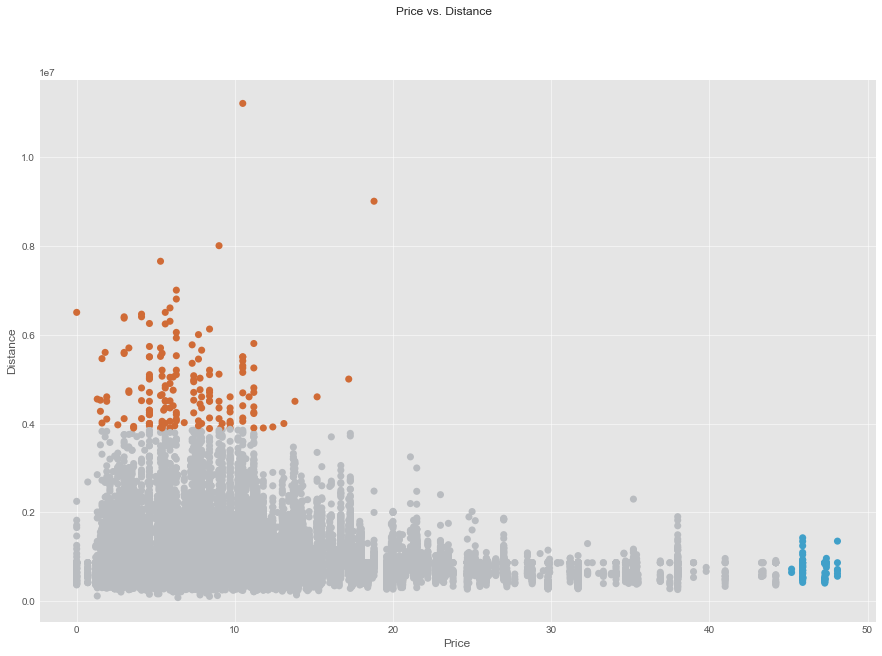

In [524]:
# This part helps us to generate a color array with different colors for the 1D outliers we compute

# first create an empty list
colorColumn = []
# we make use of the HEX color codes to use nicely distinguisable colors
for i in range(len(housing)):
    if housing["isOutlierPrice"][i]== 1:
        colorColumn.append("#D06B36") # orange color
    elif housing["isOutlierDistance"][i] == 1:
        colorColumn.append("#40A0C9") # a blueish color
    else:
        colorColumn.append("#B9BCC0") # gray

plt.figure(figsize=(15,10))
plt.xlabel('Price')
plt.suptitle('Price vs. Distance')
plt.ylabel('Distance')
plt.scatter(housing.Distance, housing.Price , c = colorColumn, s = 50, linewidth='0')

A 'Price' outlier clearly stands out: it is well beyond 7 standard deviation from the mean of the distribution (it's exact value is 11.200.000 dollars). Let's take a closer look to this property. 

In [393]:
#take just the price outlier
housing.iloc[:,:19][housing.Price > 11000000]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
25635,Brighton,6 Cole St,4,h,11200000.0,VB,hockingstuart,28/10/2017,10.5,3186.0,3,2,1400.0,136.0,1970.0,Bayside City Council,-37.89335,144.98643,Southern Metropolitan


So we now know that this house it's located at Brighton, which according to Wikipedia 'houses some of the wealthiest citizens in Melbourne'. The house is probably a cottage (Type h) on the sea.

The revious visualization was a simple 1D outlier measure: each point was either an outlier either for price or distance. But what about those points that are 2D outliers, that is on the edge of the distribution for both variables? In order to detect those points we need high-dimensional methods. Mahalanobis distance is one such measure, which will help to realize our next graph. 

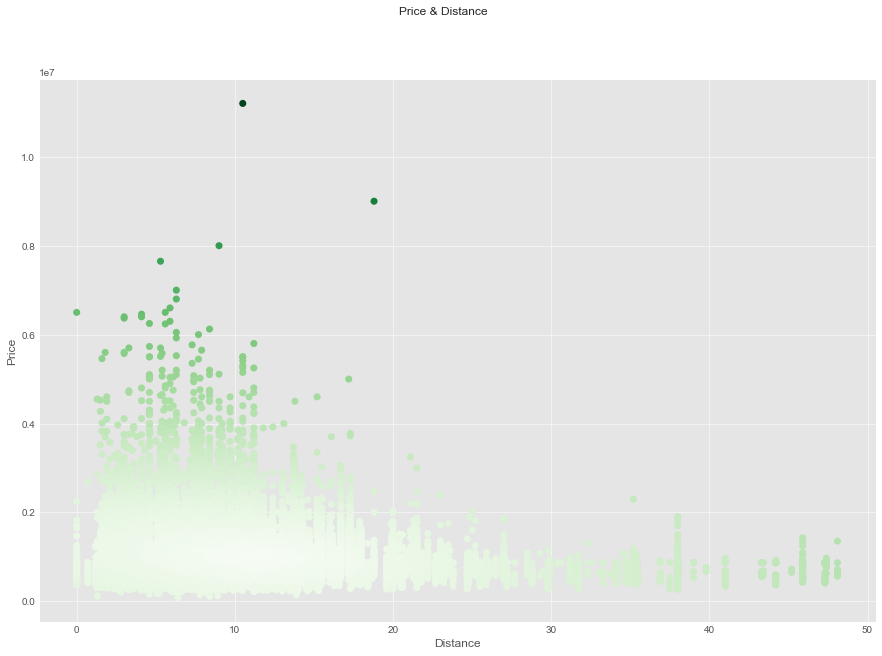

In [394]:
# We now get a part of the data frame as a numpy matrix to use in scipy
housing.dropna()
columnValues = housing.as_matrix(["Price", "Distance"])

# In order to generate a "mean vector", we use the mean values already computed above.
# Notice that we make use of the reshape() function to get the mean vector in a compatible shape
# as the data values.
meanVector = np.asarray([meanPrice, meanDistance]).reshape(1,2)

# We make us of the scipy function which does the computations itself.
# Alternatively, one can provide a covariance matrix that is computed outside as a parameter.
# In cases where robustness of the covariance matrix is the issue, this can be a good option.

# first import the spatial subpackage from scipy
from scipy import spatial
mahalanobisDistances = spatial.distance.cdist(columnValues, meanVector, 'mahalanobis')[:,0]

# We create a new figure where we use a color mapping and use the computed mahalanobis distances 
# as the mapping value
plt.figure(figsize=(15,10))
plt.xlabel('Distance')
plt.suptitle('Price & Distance')
plt.ylabel('Price')
plt.scatter(housing.Distance, housing.Price , c = mahalanobisDistances, cmap = plt.cm.Greens, s = 50, linewidth='0')

We can see that more "central" points have a low Mahalanobis distance (white points), while those on the outskirts have more saturated colors, i.e., higher distance to the centre. In this plot, the only clear 2D outliers are the dark points on the top left corner. Notice that Mahalanobis distance is particularly suited for elliptical relationship between variables (and this is not one of them). In any case is a nice visual method to identify groups of potentially interesting outliers. 

<a id='features'></a>

## 2.3 Feature engineering

* create variable number of years since building

In [247]:
housing['houseAge'] = 2018-housing['YearBuilt']

* Then create two new categories from the variable Date: year and season.

In [248]:
#create the new column data restructuring the original Date column with pd.to_datetime
housing['data'] = pd.to_datetime(housing['Date'])

In [249]:
# calculate day of year
housing['doy'] = housing['data'].dt.dayofyear
# Create year
housing['Year'] = housing['data'].dt.year

#to divide by season it's better to use the day of the year instead of the months
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

daje = []
for i in housing['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    daje.append(season)   

#add the resulting column to the dataframe (after transforming it as a Series)
housing['season']= pd.Series(daje)

In [250]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34780 entries, 0 to 34856
Data columns (total 27 columns):
Suburb               34780 non-null object
Address              34780 non-null object
Rooms                34780 non-null int64
Type                 34780 non-null object
Price                34780 non-null float64
Method               34780 non-null object
SellerG              34780 non-null object
Date                 34780 non-null object
Distance             34780 non-null float64
Postcode             34780 non-null float64
Bathroom             34780 non-null int32
Car                  34780 non-null int32
Landsize             34780 non-null float64
BuildingArea         34780 non-null float64
YearBuilt            34780 non-null float64
CouncilArea          34780 non-null object
Lattitude            34780 non-null float64
Longtitude           34780 non-null float64
Regionname           34780 non-null object
Propertycount        34780 non-null float64
isOutlierPrice       3478

## Test-Train Split
To test the performances of our algorithms I will split the dataset into two distinct train and test sets.

In [251]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing = train_set.copy()

<a id='visualisation'></a>

## 3. Visualisations

I will explore only the train set to avoid data snooping as much as possible

<a id='box'></a>

### 3.1 Boxplots and histograms

First I will create my color palette

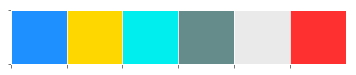

In [252]:
#create my palette
myPal = ["#1E90FF", "#FFD700", "#00EEEE", "#668B8B", "#EAEAEA", "#FF3030"]
sns.set_palette(myPal)
sns.palplot(sns.color_palette())

First let's check with boxplots the distribution of ordinal and categorical values

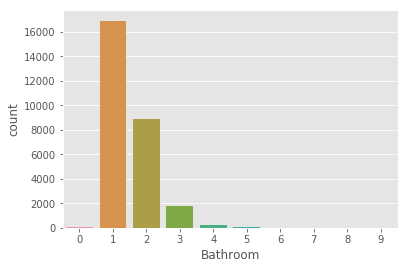

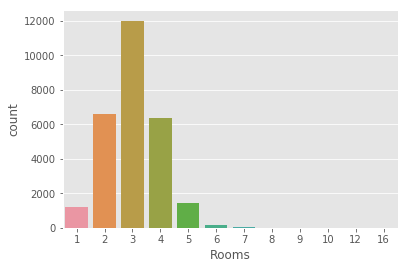

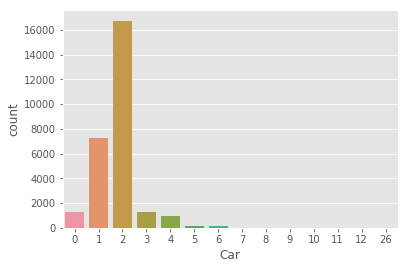

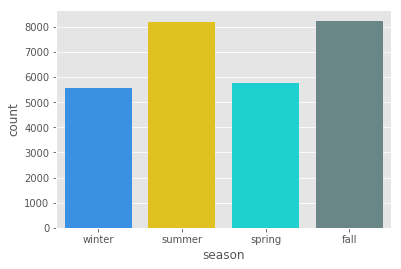

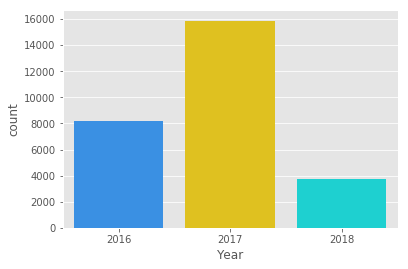

In [253]:
l= ['Bathroom', 'Rooms', 'Car', 'season', 'Year']
for i in l:
    plt.figure()
    sns.countplot(x=i, data=housing)

**Insights**:

* most properties were sold on 2017;
* More properties are sold during summer and fall;
* most houses have space for 2 cars;
* between 2 to four rooms and 1 or 2 bathrooms;

Now I'll take a look at the distribution of continous variables using histograms

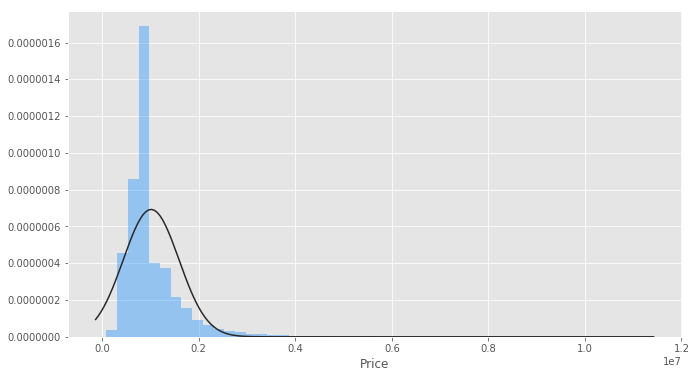

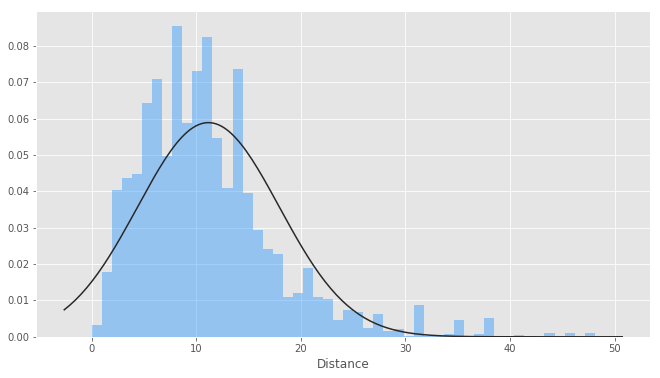

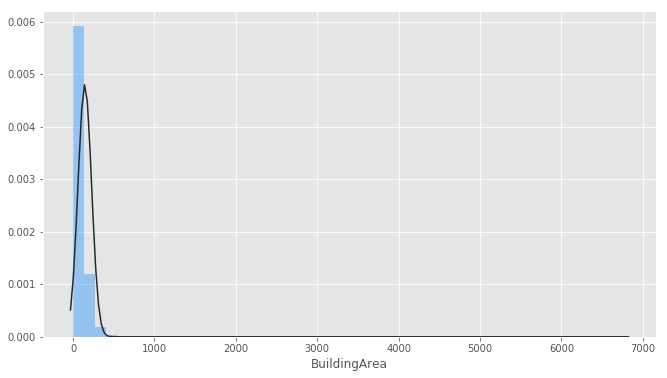

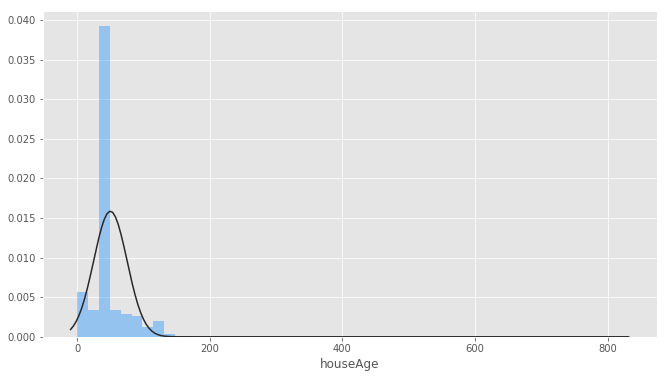

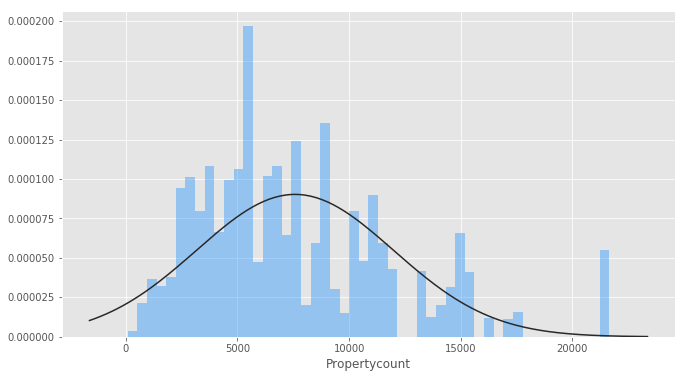

In [254]:
l= [housing['Price'], housing['Distance'], housing['BuildingArea'], housing['houseAge'], housing['Propertycount']]
for i in l:
    plt.figure(figsize=(11,6))
    sns.distplot(i, fit=norm, kde=False)

Let's zoom in for Building Area, which is not very clear by the last graph

(0, 1000)

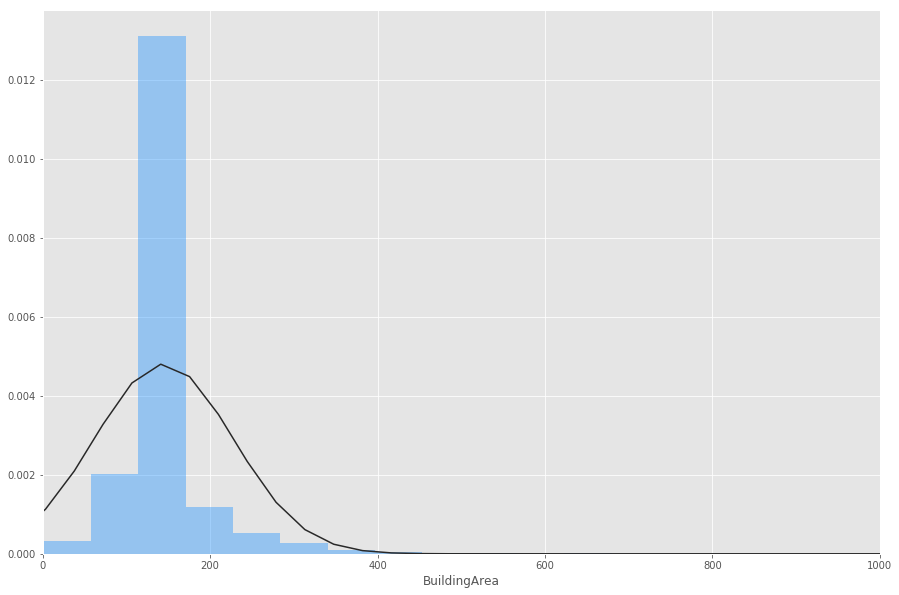

In [255]:
plt.figure(figsize=(15,10))
sns.distplot(housing['BuildingArea'], fit=norm, bins=120, kde=False)
plt.xlim(0,1000)

Biggest insight here is that all variables have a different scale, there are many outliers for most of them and no one seem really close to normality. These observations will come useful later when I will scale my features. 

Now let us check some variables that may influence our dependent variable price. 

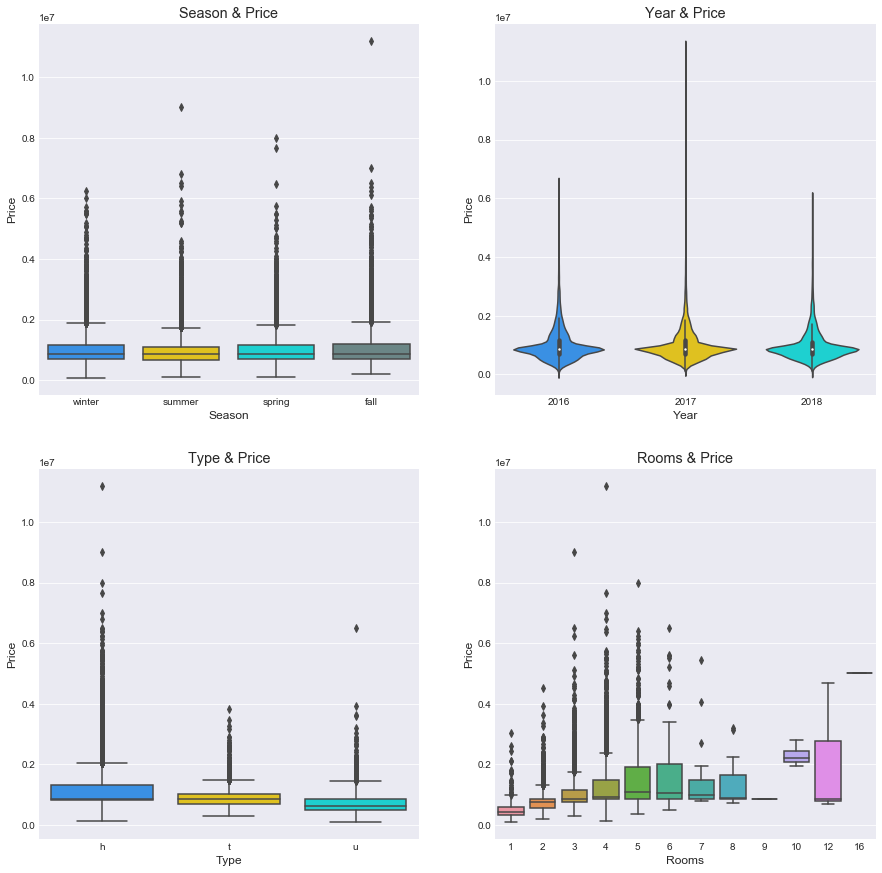

In [256]:
# Suplots of categorical features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = housing, x = 'season', y = 'Price', ax = axes[0, 0])
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Season & Price')

# Plot [0,1]
sns.violinplot(data = housing, x = 'Year', y = 'Price', ax = axes[0, 1])
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Year & Price')

# Plot [1,0]
sns.boxplot(x = 'Type', y = 'Price', data = housing, ax = axes[1,0])
axes[1,0].set_xlabel('Type')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Type & Price')

# Plot [1,1]
sns.boxplot(x = 'Rooms', y = 'Price', data = housing, ax = axes[1,1])
axes[1,1].set_xlabel('Rooms')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Rooms & Price')

* Regarding season, there is no big diffence in price between houses sold on different parts of the year;  
* As for years, 2017 was the best year for the market, with apparently more high price outliers. 2018 has less activity, perhaps because data collection did not include the whole year. 
* It seems that there is a slight linear increase in Price for more rooms. Note that not all the levels of variable rooms are very stable, with 9 and 16 showing very little variability (they surely have few cases).
* Type of house may be an important indicator for price, as is seems that h (cottages) cost more, and have more variability in price. 

<a id='time'></a>

### 3.2. Time series

My first idea was obviously to organize the longitudinal plot wth days on the x-axis and price as y. Considering the size of the dataset I expected to have house sales for almost every day. Unexpectedly, out of all the 2 and a half years, houses were sold only during 78 days (see below the shape computation). I thus decided to order the x-axis by month (but even by week would have been possible). Y-axis represents the total amount of money spent in the housing market during the period of interest. 

In [257]:
#use shape to count the number of rows of the database grouped by day using a pivot table.
housing.pivot_table('Price', index='data', aggfunc='sum').shape

(78, 1)

([<matplotlib.axis.XTick at 0x19ee8424898>,
 <a list of 13 Text xticklabel objects>)

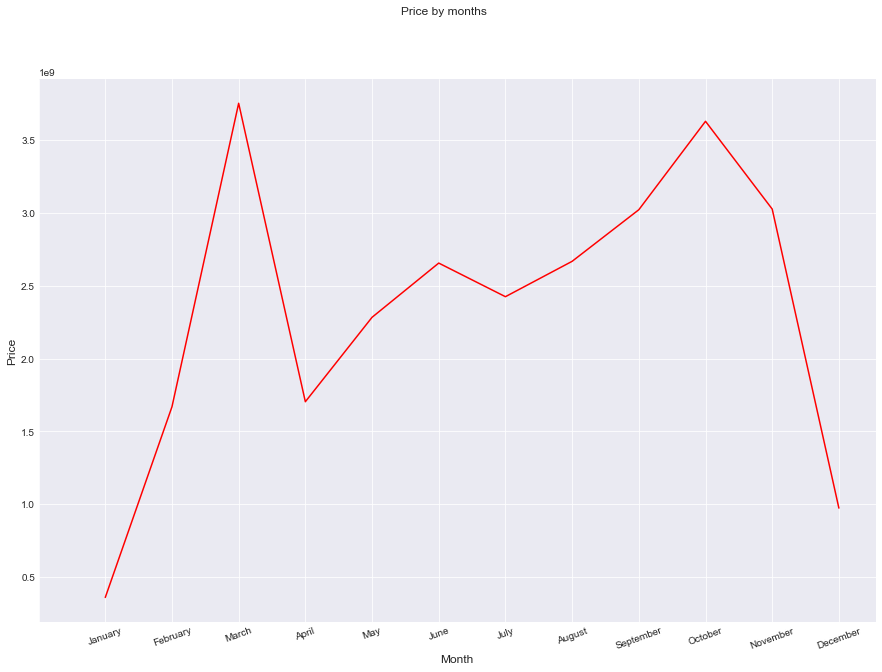

In [258]:
import calendar
# create new column storing the month of each operation
housing['month'] = housing['data'].dt.month
#use group by (alternative to pivot_table) to have the total value of houses sold per month
by_month= housing.groupby('month')['Price'].sum()
#plot figure
plt.figure(figsize=(15,10))
plt.plot(by_month, color="red")
plt.xlabel('Month')
plt.suptitle('Price by months')
plt.ylabel('Price')
plt.xticks(np.arange(13), calendar.month_name[0:13], rotation=20)

In the graph above I simply consider Price by month, similarly to what I did before with boxplots. However, we want to take into account also the year variable. The graph below shows the value of sales by month from 2016 to 2018. Note that in this case also, not all months have been profitable. In fact, only 28 months have been registered in the database, with many months in 2018 missing, as you can see from the x-axis of the graph. 

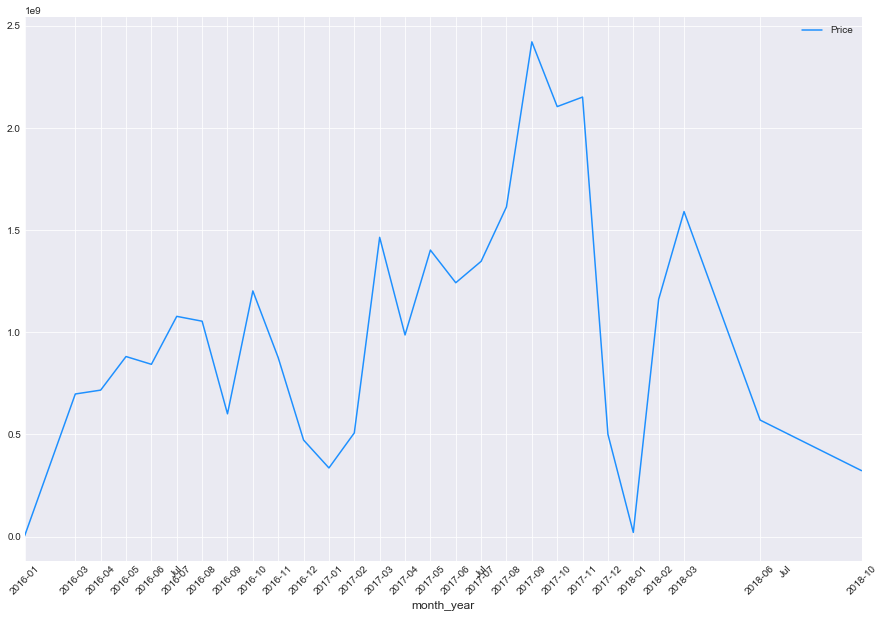

In [262]:
#create index month-year
housing['month_year'] = housing['data'].dt.to_period('M')
#use groupby to compute the price for each available month, then store the result in a dataframe
by_year_month= pd.Series.to_frame(housing.groupby('month_year')['Price'].sum())
#draw graph
fig, ax = plt.subplots(figsize=(15,10))
by_year_month.plot(ax=ax, xticks=by_year_month.index, rot=45)
ax.set_xticklabels(by_year_month.index)

<a id='correlation'></a>

### 3.3. Correlation matrix and scatterplots
It is high time to have a look at the correlations between our variables. First I will draw a correlation matrix, and then I will visualize the most promising relationship with scatterplots. 

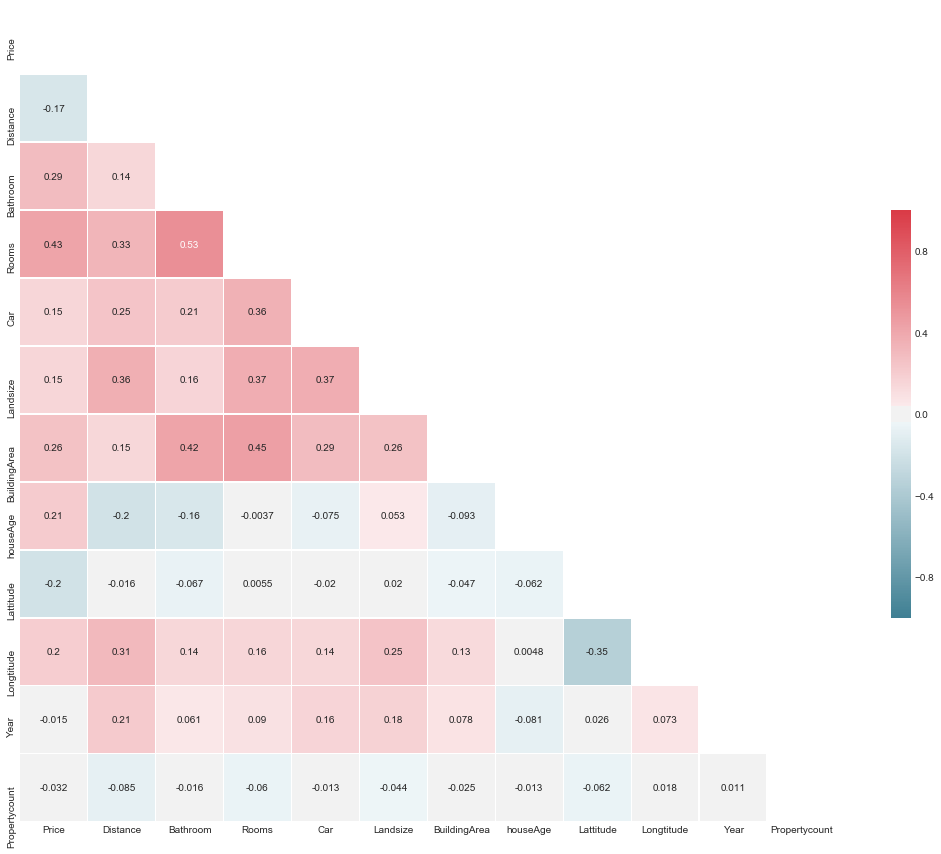

In [263]:
#select only the data we are interested in
attributes= ['Price', 'Distance', 'Bathroom', 'Rooms', 'Car', 'Landsize', 'BuildingArea', 'houseAge', 'Lattitude', 'Longtitude', 
             'Year', 'Propertycount']
h= housing[attributes]

#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=h.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(20,15))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

I will now examine the relationship between Price and four other variables:
* BuildingArea (r= .26)
* HouseAge (.21)
* Rooms - This is the strongest relationship (.43). 
* Distance - most negative correlation (-.17)

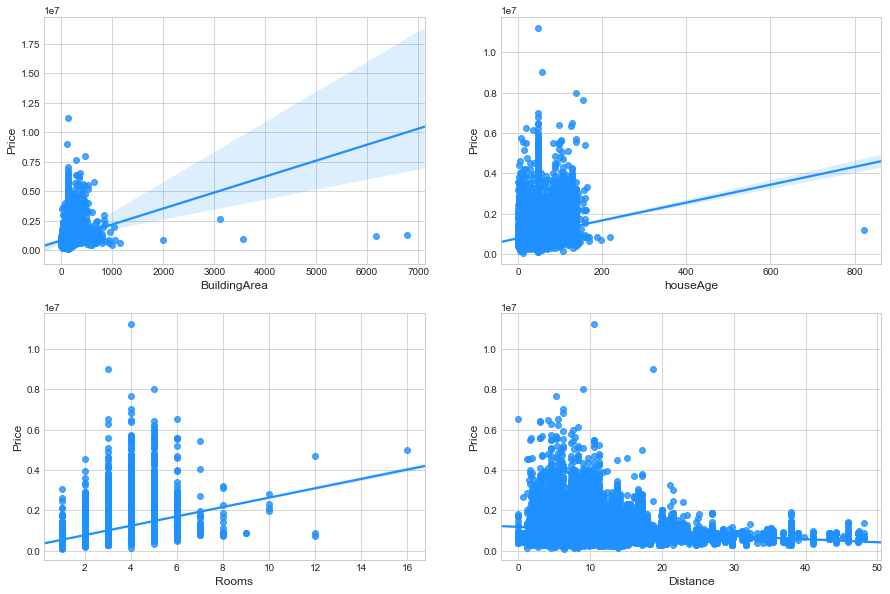

In [264]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= housing, x='BuildingArea', y='Price')
plt.subplot(222)
sns.regplot(data= housing, x='houseAge', y='Price')
plt.subplot(223)
sns.regplot(data= housing, x='Rooms', y='Price')
plt.subplot(224)
sns.regplot(data= housing, x='Distance', y='Price')

Seaborn provides other interesting options to visualize a bivariate relationship, like the jointplot below. This time I used a trick to stop some useless warning that I was not able to fix in any other way.

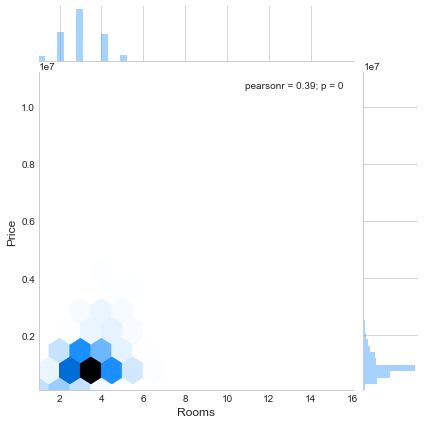

In [265]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Price and distance
    sns.jointplot(y='Price', x='Rooms', data=housing, kind='hex', gridsize=15)

Is the type of house influencing the relationship of the variables we examined? For example, when a townhouse gets old I think that it loses value, as we tend to prize more modern venues in western cities. But what about an historical villa deep into the countryside? In that case I think that the price may well increase as the property ages, like a vintage item. 

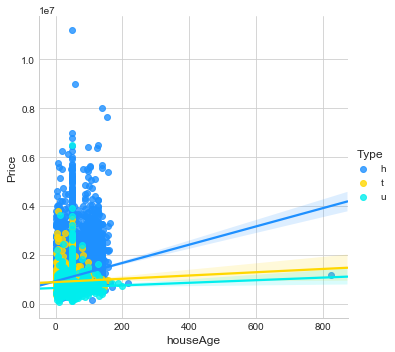

In [266]:
sns.lmplot(data= housing, x='houseAge', y= 'Price', hue= 'Type')

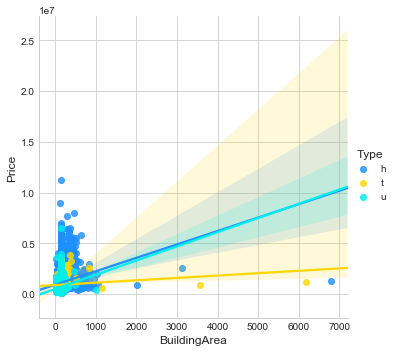

In [267]:
sns.lmplot(data= housing, x='BuildingArea', y= 'Price', hue='Type')

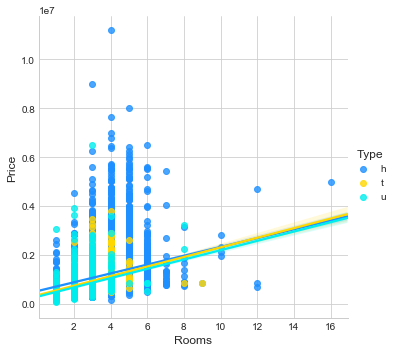

In [268]:
sns.lmplot(data= housing, x='Rooms', y= 'Price', hue='Type')

Indeed, it seems that there is an interaction between type of house and its age to determine the price: as the house gets older, the price increases on average, but this is particularly true for Type h, that is cottages and villas. 
A similar interaction is shown in the second graph, where we see that the price steeply increases for larger properties (bigger BuildingArea), but not for the townhouse Type.
On the contrary, Type does not seem to influence the relationship between price and rooms: the more rooms, the better. This baffles me, as I would have expected the same result as in BuildingArea. Any ideas on how to comment these diverging results?

<a id='geo'></a>

### 3.4. Geographical Data

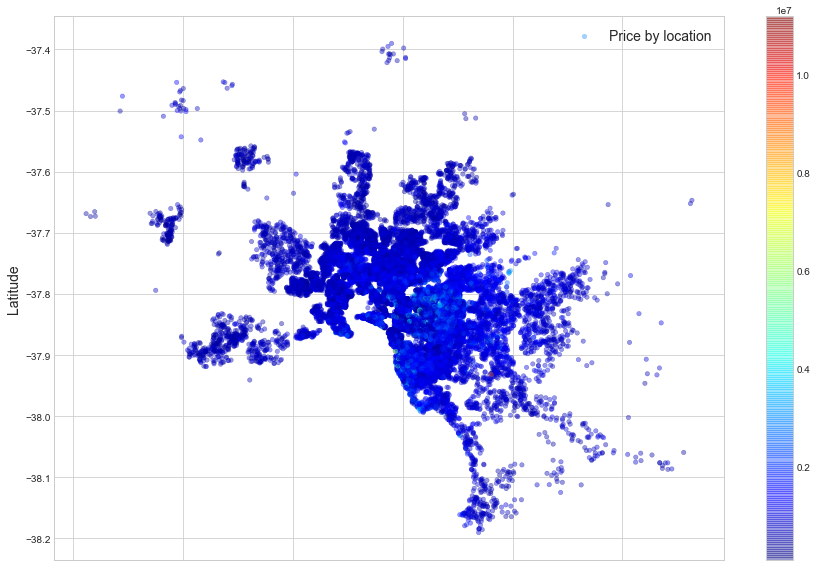

In [269]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=housing.Price, cmap=plt.get_cmap("jet"), label= 'Price by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This plot is quite confusing, because most values are in the low end of the Price range and they turn out as blue. Perhaps it would be better to first delete the most extreme outliers (let's say 5 std from the mean) and then plot the figure? I also tried normalising the price variable (with log transformation and standard scaler) but this resulted in a completely green map, that is a map dominated by middle values. Please let me know your suggestions in the comment section, if you have any.

In [271]:
housing['Price_cut']= housing['Price'].loc[housing.Price<3500000]

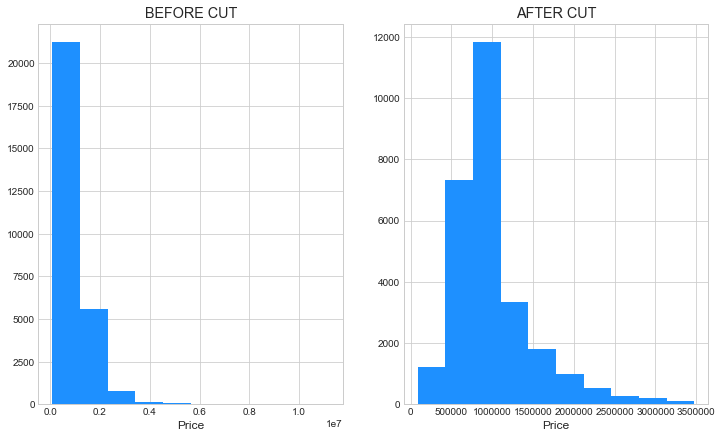

In [276]:
f, axes = plt.subplots(1,2, figsize = (12,7))
# Plot [0,0] full price
housing['Price'].hist(ax = axes[0])
axes[0].set_title('BEFORE CUT')
axes[0].set_xlabel('Price')
# Plot [0,1] price cut
housing['Price_cut'].hist(ax = axes[1])
axes[1].set_xlabel('Price')
axes[1].set_title('AFTER CUT')

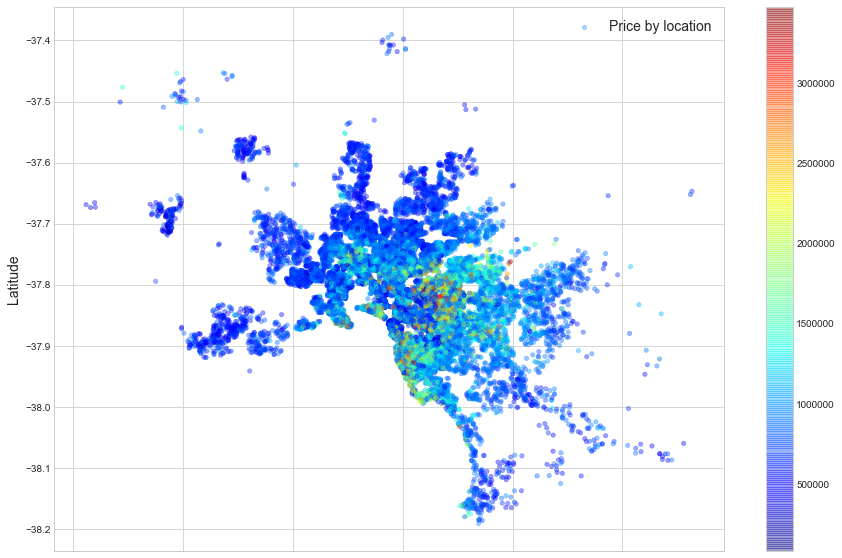

In [277]:
housing.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=housing.Price_cut, cmap=plt.get_cmap("jet"), label= 'Price by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This map let us see that most expensive properties are in a central area not too far from what I think is the sea. Next step would be to superimpose on this scatterplot a real map of the city.

<a id='ml'></a>

# 4. Machine learning

**One-hot encoding** for categorical variables

In [291]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27824 entries, 34662 to 15796
Data columns (total 30 columns):
Suburb               27824 non-null object
Address              27824 non-null object
Rooms                27824 non-null int64
Type                 27824 non-null object
Price                27824 non-null float64
Method               27824 non-null object
SellerG              27824 non-null object
Date                 27824 non-null object
Distance             27824 non-null float64
Postcode             27824 non-null float64
Bathroom             27824 non-null int32
Car                  27824 non-null int32
Landsize             27824 non-null float64
BuildingArea         27824 non-null float64
YearBuilt            27824 non-null float64
CouncilArea          27824 non-null object
Lattitude            27824 non-null float64
Longtitude           27824 non-null float64
Regionname           27824 non-null object
Propertycount        27824 non-null float64
isOutlierPrice       

In [292]:
#dummy variable
hD= pd.get_dummies(housing, columns= ['Type', 'Regionname', 'season'])
#drop useless variables
hD= hD.drop(['Suburb', 'Address', 'Method', 'SellerG', 'Date', 'Postcode', 'CouncilArea', 'isOutlierPrice', 'isOutlierDistance',
            'YearBuilt', 'data', 'doy', 'month', 'month_year', 'Price_cut'], axis=1)
#check variables
hD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27824 entries, 34662 to 15796
Data columns (total 27 columns):
Rooms                                    27824 non-null int64
Price                                    27824 non-null float64
Distance                                 27824 non-null float64
Bathroom                                 27824 non-null int32
Car                                      27824 non-null int32
Landsize                                 27824 non-null float64
BuildingArea                             27824 non-null float64
Lattitude                                27824 non-null float64
Longtitude                               27824 non-null float64
Propertycount                            27824 non-null float64
houseAge                                 27824 non-null float64
Year                                     27824 non-null int64
Type_h                                   27824 non-null uint8
Type_t                                   27824 non-null uint8
Typ

**Feature Scaling**

Our features have very different scales: room ranges from 1 to 16, while Price is in the range of millions. this difference can hinder the performance of our ML algorithms. I will thus apply a scaling algorithm. In this scenario is probably best to implement a robust scaling, which is not bound to Gaussian distribution of features and can deal with outliers, instead of the more common standard scaler or min-max scaling. [This resource](http://benalexkeen.com/feature-scaling-with-scikit-learn/) explains really well all the available options and their statistical meaning. For a still more detailed explanation, this [scikit-learn page](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) is very interesting.

In [293]:
#create x and y variables
X = hD.drop("Price", axis=1)
Y = hD["Price"].copy()
#transform to array size
#feature scaling
scaler = RobustScaler()
hD= scaler.fit_transform(hD.astype(np.float64))

In [294]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 42)

Now finally I will try to predict price using three basic ML methods: linear regression, decision trees and random forest. I will first prepare the inputs (feature scaling and one-hot encoding), then I will apply the models to the train set. RMSE will be the major metrics to evaluate the performances of the models. Cross-validation will also be used to select the best performing model, which I will then fine tune.  

Fit our three basic models...

In [295]:
#fit decision tree
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
#fit random forest
forest = RandomForestRegressor(n_jobs=-1)
forest.fit(x_train, y_train)
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

... and then test them on train data, in terms of MSE:

In [296]:
models= [('lin_reg', lin_reg), ('random forest', forest), ('decision tree', tree)]
from sklearn.metrics import mean_squared_error
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 452684.97
RMSE of random forest = 205849.23
RMSE of decision tree = 93634.36


We can use the Mean absolute percentage error (MAPE) to compute a measure of accuracy that is more immediate to understand.

In [297]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(x_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 70.92 %
Accuracy of random forest= 89.21 %
Accuracy of decision tree= 98.09 %


These results are interesting: it seems that decision tree is by far the best model, as its error is the lowest. However, at this point we are only evaluating our models on the train set, so the risk of overfitting for decision trees is quite high. To understand better the performances of the models we can use an alternative strategy: cross-validation. 

<a id='compare'></a>

## 4.1 Model comparison

I will cross-validate the three models and compare them 

To understand better the distinction between MAE and RMSE read this [useful resourse](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

In [298]:
models= [('lin_reg', lin_reg), ('forest', forest), ('dt', tree)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#for each model I want to test three different scoring metrics. Therefore, results[0] will be lin_reg x MSE, 
# results[1] lin_reg x MSE and so on until results [8], where we stored dt x r2

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [299]:
#this is an example of the stored results
results[8]

{'fit_time': array([0.15625429, 0.21237588, 0.2273972 , 0.18151426, 0.15739274,
        0.17448092, 0.2393589 , 0.19248486, 0.16376543, 0.15624642]),
 'score_time': array([0.        , 0.00198054, 0.0019908 , 0.00099802, 0.        ,
        0.0009985 , 0.00199676, 0.00302267, 0.        , 0.0155859 ]),
 'test_score': array([ 0.01205678, -0.06892211,  0.08259886, -0.0470497 , -0.00057085,
        -0.04324626, -0.03003725,  0.15577929,  0.04027249, -0.08655315]),
 'train_score': array([0.97362779, 0.97741567, 0.97507825, 0.97492382, 0.97864395,
        0.97378154, 0.97582969, 0.97524028, 0.97430704, 0.97396426])}

Now I want to compute for each combination the mean and std, so that to put into a dataframe all the metrics and easily compare them

In [300]:
#THIS IS FOR Linear regression
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

#THIS IS FOR RF
RF_RMSE_mean = np.sqrt(-results[3]['test_score'].mean())
RF_RMSE_std= results[3]['test_score'].std()
RF_MAE_mean = -results[4]['test_score'].mean()
RF_MAE_std= results[4]['test_score'].std()
RF_r2_mean = results[5]['test_score'].mean()
RF_r2_std = results[5]['test_score'].std()

#THIS IS FOR DT
DT_RMSE_mean = np.sqrt(-results[6]['test_score'].mean())
DT_RMSE_std= results[6]['test_score'].std()
DT_MAE_mean = -results[7]['test_score'].mean()
DT_MAE_std= results[7]['test_score'].std()
DT_r2_mean = results[8]['test_score'].mean()
DT_r2_std = results[8]['test_score'].std()

<a id='models'></a>

In [301]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression', 'Random Forest', 'Decision Trees'],
    'RMSE_mean'    : [LR_RMSE_mean, RF_RMSE_mean, DT_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std, RF_RMSE_std, DT_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean, RF_MAE_mean, DT_MAE_mean],
    'MAE_std'   : [LR_MAE_std, RF_MAE_std, DT_MAE_std],
    'r2_mean'      : [LR_r2_mean, RF_r2_mean, DT_r2_mean],
    'r2_std'      : [LR_r2_std, RF_r2_std, DT_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
1,Random Forest,446027.189974,2.722396e+10,258505.317031,8151.581437,0.419380,0.036153
0,Linear Regression,454126.464105,2.175672e+10,286448.661343,8493.684497,0.383991,0.018067
2,Decision Trees,577844.109783,2.413589e+10,314755.800543,9316.375571,0.001433,0.070756


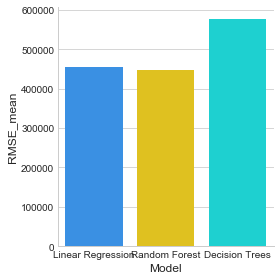

In [304]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

Now decision trees are not so good in comparison with the other two methods, both in terms of error and variance explained. The best model is random forest, though I must say that I expected it to outperform linear regression by a wider margin. In any case, let's proceed with fine tuning our random forest. 

<a id='tune'></a>

## 4.2. Fine-tune Random Forest

<a id='grid'></a>

### a. Grid Search

In this grid search I will try different combinations of RF hyperparameters. 

**Most important hyperparameters of Random Forest:**
* n_estimators = n of trees
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement) 

As for how I decided the numbers to try I simply followed the advice of Aurelion Geron (2017): '*When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search)'.*

In [305]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_forest.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 25], 'max_features': [5, 10], 'max_depth': [10, 50, None], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [307]:
#now let's how the RMSE changes for each parameter configuration
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

428844.6799194675 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 10}
426430.9910859637 {'bootstrap': True, 'max_depth': 10, 'max_features': 5, 'n_estimators': 25}
428501.9745561084 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 10}
421630.39429849584 {'bootstrap': True, 'max_depth': 10, 'max_features': 10, 'n_estimators': 25}
442508.9253727256 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 10}
424283.5447250491 {'bootstrap': True, 'max_depth': 50, 'max_features': 5, 'n_estimators': 25}
437567.3483556171 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 10}
426762.06767292426 {'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}
436224.05767097406 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 10}
427085.6912071659 {'bootstrap': True, 'max_depth': None, 'max_features': 5, 'n_estimators': 25}
437378.2298971225 {'bootstrap': True, 'max_depth'

In [308]:
#find the best model of grid search
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [347]:
# Performance metrics
grid_best= grid_search_forest.best_estimator_.predict(x_train)
errors = abs(grid_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from grid-search has an accuracy of', round(accuracy, 2),'%')

The best model from grid-search has an accuracy of 77.27 %


In [351]:
#RMSE
grid_mse = mean_squared_error(y_train, grid_best)
grid_rmse = np.sqrt(grid_mse)
print('The best model from the grid search has a RMSE of', round(grid_rmse, 2))

The best model from the grid search has a RMSE of 365356.56


<a id='random'></a>

### b. Randomized search

The grid search approach is often too costly, as many combinations are tested. In these cases it is easier to use a randomized search, that evaluates a only an user defined number of random combinations for each hyperparameter at every iteration. This way we could also test more hyperparameters. 
See this [tutorial](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb) and this [resource](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74), with its [notebook](https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb).

In [310]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [311]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [20, 65, 110, 155, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 23, 45], 'min_samples_split': [5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2)

In [312]:
#now let's how the RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

547465.7325443769 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
547513.3798043159 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 1}
416026.38536751264 {'n_estimators': 65, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
425743.78779796493 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
539739.0149633811 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
415309.35258103936 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
414742.24624680233 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
421890.26481124276 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
540077.6379759012 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
415418.21260692633 {'n_estimators': 110, 'min_samples_

Best RMSE is (416575.2611)

In [313]:
# best random model 
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=155, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [314]:
# best combination of parameters of random search
rf_random.best_params_

{'max_depth': 23,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 155}

In [316]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=155, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Now, let's find out about the performance metrics of our new model: MAPE and RMSE. 

In [349]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(x_train)
errors = abs(random_best - y_train)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model from the randomized search has an accuracy of', round(accuracy, 2),'%')

The best model from the randomized search has an accuracy of 85.74 %


In [350]:
#this is the RMSE
final_mse = mean_squared_error(y_train, random_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the randomized search has a RMSE of', round(final_rmse, 2))

The best model from the randomized search has a RMSE of 243924.85


In conclusion, the metrics for our best models on the training set after our hyperparameter fine-tuning are the following:

1. **Grid-search**:
    * RMSE: 365356.56
    * accuracy (MAPE): 77.27 %
    
    
2. **Randomized Search**:
    * RMSE: 243924.85
    * accuracy: 85.74 %
    
This of course does not mean that the grid-search is inherently inferior to randomized search. It's just that in this notebook I used the information provided by the former to refine the latter. Moreover, I tested more combinations with the randomized search. In any case, this time I will consider the model obtained by the randomized search as the best one. First I will plot the feature importance for this model. This will give me precious insight to the most important factor in predicting our dependent variable Price. Then I will apply the model to the test set. 

**Feature Importance**

In [322]:
# extract the numerical values of feature importance from the grid search
importances = rf_random.best_estimator_.feature_importances_

#create a feature list from the original dataset (list of columns)
# What are this numbers? Let's get back to the columns of the original dataset
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

#see df
print(df)

    importance                                feature
0     0.121958                               Distance
1     0.096828                                  Rooms
2     0.089412                             Longtitude
3     0.089205                              Lattitude
4     0.086631                               Landsize
5     0.084358       Regionname_Southern Metropolitan
6     0.066263                           BuildingArea
7     0.059645                          Propertycount
8     0.051921                               Bathroom
9     0.049771                               houseAge
10    0.049077                                 Type_h
11    0.048190                                 Type_u
12    0.025518                                    Car
13    0.016556                                   Year
14    0.009693        Regionname_Western Metropolitan
15    0.008613                            season_fall
16    0.007981       Regionname_Northern Metropolitan
17    0.007712              

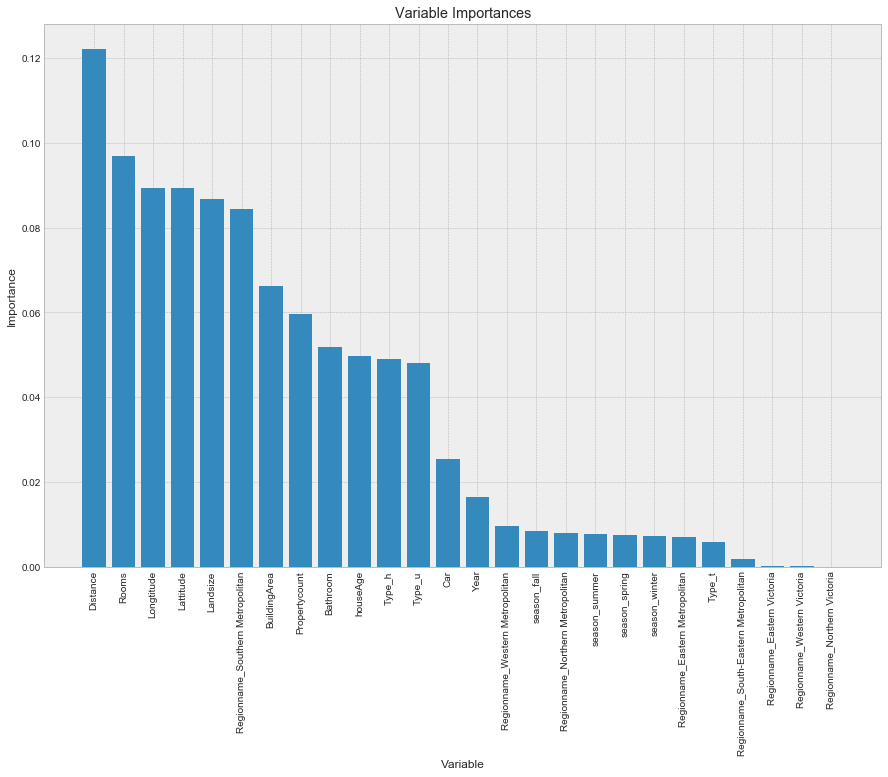

In [323]:
# Set the style
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range(len(feature_importance)))

# Make a bar chart
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

A future aim may be to cut the less relevant features (let's say everything after 'car' in terms of importance), estimate a new model and compare it with the old ones. I reckon it would lose predictive power, but on the other hand it would gain in terms of training speed.  

### In conclusion, these are my final considerations on the model: 
* the best feature to reliably predict the price of a Melbourne house is Distance. After distance that there is a group of 5 features including: number of rooms, Longitude and Latitude, and Southern Metropolitan region. This last dummy attribute is the only one relevant out of the original group of 7 regions. Thus, it seems that the best features are primarily related to the house location, and then to its size (there is also Building size to consider). This is why I chose that title!
* The type of the house seems less important than these two categories, as houseAge and Type_h are respectively 10th and 11th in this ranking. Category Type_t (or townhouse) is the less relevant feature in this cluster. 
* Date features (i.e. Year and the four seasons) are not that important, but in any case the year when the house was sold is slightly more important than the season.

<a id='evaluate'></a>

## 4.3. Evaluate best model on the test set

In [334]:
final_model = rf_random.best_estimator_
# Predicting test set results
final_pred = final_model.predict(x_test)
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 405478.82


In [335]:
#calculate accuracy
errors = abs(final_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / y_test))
# Calculate and display accuracy
accuracy = 100 - mape    
#print result
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 75.91 %


As was to be expected, the performance drops considerably, but is still  beyond 75%, which I consider a discrete result. 

<a id='hyper'></a>

## 5. P.S. Visualize Random Forest Hyperparameters
I thought to dedicate a last visualization to one of the major hyperparameter that I tweaked in my training: max_depth. Of course this could be done with all the other parameters, but considering it was only a closing remark extending this part seemed pretty useless. 

### max_depth
Max_depth indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. In our search we considered a depth ranging from 1 to 50 on the training set. Let's compare the training result with the test result. 

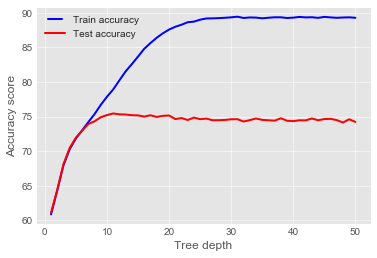

In [352]:
max_depths = np.linspace(1, 50, 50, endpoint=True)

train_results = []
test_results = []

for i in max_depths:
    dt = RandomForestRegressor(max_depth=i)
    dt.fit(x_train, y_train)    
    #compute accuracy for train data
    housing_tree = dt.predict(x_train)
    errors = abs(housing_tree - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_train)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #append results of accuracy
    train_results.append(accuracy)
    
    #now again for test data
    housing_tree = dt.predict(x_test)
    errors = abs(housing_tree - y_test)
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    #append results of accuracy
    test_results.append(accuracy)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

With this graph it is really easy to see where the overfitting begins: after ~8 splits the test performance does not increase anymore, while the train stops increasing after 20 splits. In fact, the best model after random search had max_depth=23. This means that the performance of the best model could still be improved if the max_depth was decreased a bit...at least with this test set!

**Future goals**:
* more automation: write a couple of functions to speed up the pre-processing part; Build a pipeline to automate the preprocessing transformations.
* more models: I would like to try a SVM and a NN, maybe a MLP.
* improve the map.